## Logistic Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardscaler for the X_data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)
X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state=0)

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score
#logistic regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
#accuracy and roc_auc
print('accuracy: {0:.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {0:.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


In [25]:
# logistic regression parameter: penaly=(l1 or l2), C=1/alpha
# default solver doesn't support l1 penalty -> using liblinear
from sklearn.model_selection import GridSearchCV
params={'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 2, 5, 10],
        'solver':['liblinear']}
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(X_train, y_train)
print('best hyperparameter:{0}, best average accuracy:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

best hyperparameter:{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}, best average accuracy:0.985


### 5.8 Tree-based Regression

In [27]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
#data load
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)
bostonDF['PRICE']=boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 cross validations each negative MSE scores:', np.round(neg_mse_scores,2))
print('5 cross validations each RMSE scores', np.round(rmse_scores,2))
print('5 cross validations average RMSE', np.round(avg_rmse, 2))

5 cross validations each negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 cross validations each RMSE scores [2.81 3.63 4.54 6.8  4.34]
5 cross validation average RMSE 4.42


In [30]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('####', model.__class__.__name__, '####')
    print('5 cross validations average RMSE: {0:.3f}'.format(avg_rmse))

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time

start = time.time()

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(random_state=0, n_estimators=1000)
lgb_reg = LGBMRegressor(random_state=0, n_estimators=10000)

models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

print('elasped time:', time.time()-start)

#### DecisionTreeRegressor ####
5 cross validations average RMSE: 5.978
#### RandomForestRegressor ####
5 cross validations average RMSE: 4.423
#### GradientBoostingRegressor ####
5 cross validations average RMSE: 4.269
#### XGBRegressor ####
5 cross validations average RMSE: 4.251
#### LGBMRegressor ####
5 cross validations average RMSE: 4.659
elasped time: 48.66361093521118


- Feature importance

<AxesSubplot:>

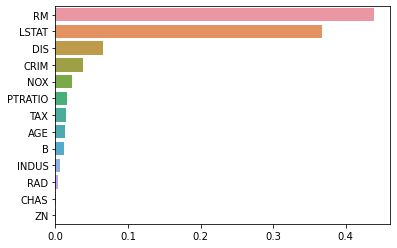

In [35]:
import seaborn as sns
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_data, y_target)
feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

- How does the tree based regressor actually work?

(100, 2)


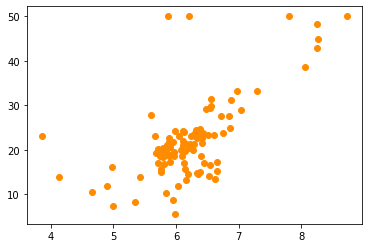

In [41]:
import matplotlib.pyplot as plt

bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression

# linear regressor, Decision tree regressor
lr_reg = LinearRegression()
dt_reg2 = DecisionTreeRegressor(max_depth=2)
dt_reg7 = DecisionTreeRegressor(max_depth=7)
# 100 test data ranging from 4.5~8.5
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# Feature and target data from dataframe
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# training
lr_reg.fit(X_feature, y_target)
dt_reg2.fit(X_feature, y_target)
dt_reg7.fit(X_feature, y_target)
# prediction
pred_lr = lr_reg.predict(X_test)
pred_dt2 = dt_reg2.predict(X_test)
pred_dt7 = dt_reg7.predict(X_test)

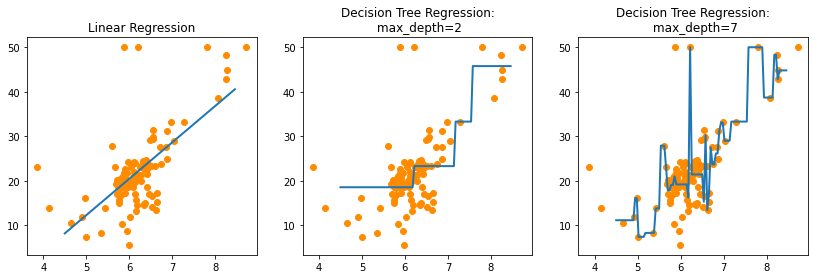

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X_test ranging from 4.5~8.5 -> predicted with linear regression, decision tree)
# linear regression
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegressor with max_depth = 2
ax2.set_title('Decision Tree Regression:\n max_depth=2')
ax2.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')
ax2.plot(X_test, pred_dt2, label='max_depth:2', linewidth=2)

# DecisionTreeRegressor with max_depth = 7
ax3.set_title('Decision Tree Regression:\n max_depth=7')
ax3.scatter(bostonDF_sample['RM'], bostonDF_sample['PRICE'], c='darkorange')
ax3.plot(X_test, pred_dt7, label='max_depth:7', linewidth=2)

